## set packages

In [28]:
#set packages
import pandas as pd
import numpy as np
import pprint as pp 
import scipy.stats as st
from dfply import *

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics as m

## Import data

In [70]:
# Set seed
np.random.seed(1234)
turnout = pd.read_csv("turnout.csv")



## train data

In [56]:
# Train-Test split 
#set frac to be 0.8 for 80% of training data
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)
# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,age,educate,income,vote,white
0,78,16.0,1.3131,1,1
1,72,3.0,0.6765,1,0
2,64,10.0,1.3131,1,1
3,80,8.0,1.1839,1,1
4,19,14.0,2.9072,1,1


In [57]:
N = train.shape[0]

# Subset the data by vote
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vote_1 = vote1.shape[0]/N
pr_vote_0 = vote0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



From the result we can see a roughly 3:1 split between the two groups, indicating that if we simply use the model to predict who votes, it would show that 75% votes while 25% don't

## Binary Variable

In our binary variable model we will build our model studying whether people would vote based on their race

In [32]:
# Given Vote == 1
w1_vote1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
w0_vote1 = vote1.query("white == 0").shape[0]/vote1.shape[0]


# Given CW == 0
w1_vote0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
w0_vote0 = vote0.query("white == 0").shape[0]/vote0.shape[0]


print(
f"""
Pr(white = 1 |vote = 1): {w1_vote1}
Pr(white = 0 |vote = 1): {w0_vote1}
Pr(white = 1 |vote = 0): {w1_vote0}
Pr(white = 0 |vote = 0): {w0_vote0}

""")


Pr(white = 1 |vote = 1): 0.8686868686868687
Pr(white = 0 |vote = 1): 0.13131313131313133
Pr(white = 1 |vote = 0): 0.7985436893203883
Pr(white = 0 |vote = 0): 0.20145631067961164




From this result we can see that in our model, given the condition that people votes, 87% are white while among the people who don't vote, 80% of people are vote. This indicates that the white people might have a higher willing to vote

## Continuous variable

Now we build our model on the continuous variable of age, educate level and income

In [58]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853716},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('income', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('income', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964}}


From our prediction, we can see that that the standard deviation of age variable is significantly higher, indicating that the age variable may not have a statistically significant effect on the vote status. While for the educate and income variable, we can infer that people of higher educate and income level have a higher possibility. This is intuitive as people with higher educate and income would be more interested in policy and therefore vote.

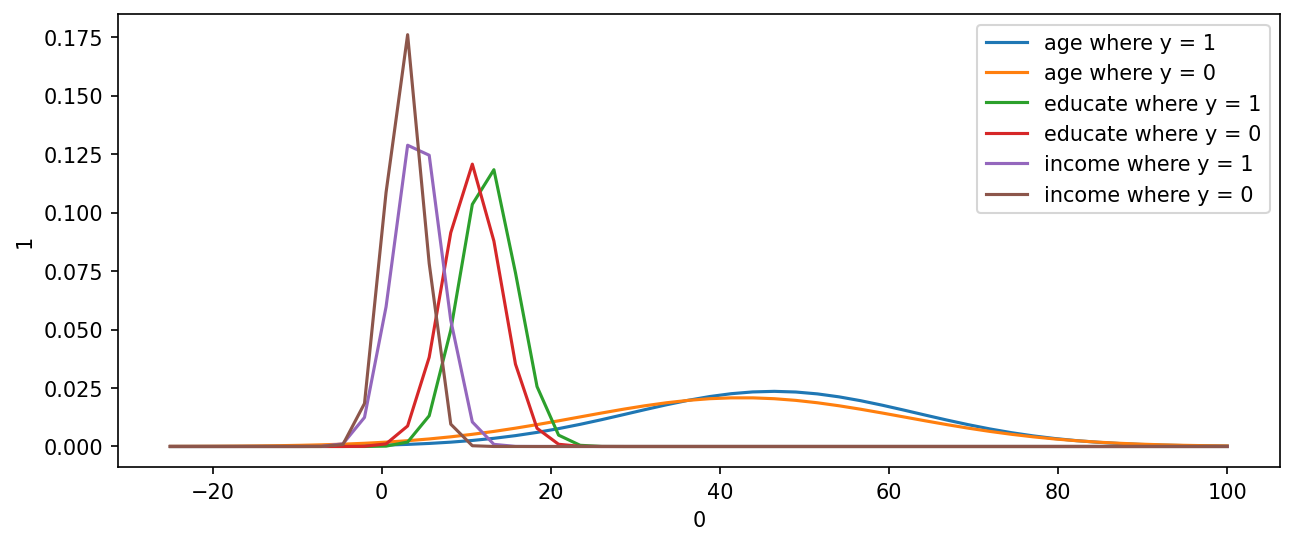

In [59]:
# Plot the pdf with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-25,100)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

In [60]:
def predict(data,dist_locs):
    '''
    
    This function utilized the training data to predict the outcome of our model.
    For the inputs, we utilized the normal distribution to obtain our model. Our inputs include the educate, age and income.
    For the outcome, the class_pred indicate our prediction on whether people would vote given the input condition
    '''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            if row.index[j] != "vote" and row.index[j] != "white":
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_vote_0
        pr_1 *= pr_vote_1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train,dist_locs)

In [61]:
preds_train.head(5)

,pr_0,pr_1,pred
0,0.001206,0.004321,1
1,0.000252,0.000086,0
2,0.004438,0.005513,1
3,0.003170,0.002730,0
4,0.003276,0.010273,1


In [62]:
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.73125

In [63]:
predTest = predict(test, dist_locs)
# See how many times the vote column matches the predicted column
accuracyTest = sum(test.vote == predTest.pred)/test.shape[0]
accuracyTest

0.7075

From our model we can see our train data have a accuracy probability of 73% while test data have an accuracy of 70%, which looks good and indicates that our model might have a rather accurate prediction.

In [64]:
# Organize our data to plug into the sklearn API easily 
train_y = train['vote']
train_x = train[['age','educate','income']]
test_y = test['vote']
test_x = test[['age','educate','income']]

In [65]:
# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.725

As we can see the sklearn API prediction method has a 72.5% of accuracy, which is very close to our former model.

In [66]:
m.roc_auc_score(test_y,y_pred)

0.5773809523809523

The area under the curve is 0.577, which indicates that the model is not very precise

In [71]:
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs.head()

,0,1
0,0.163158,0.836842
1,0.108983,0.891017
2,0.322554,0.677446
3,0.299682,0.700318
4,0.044637,0.955363


In [68]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

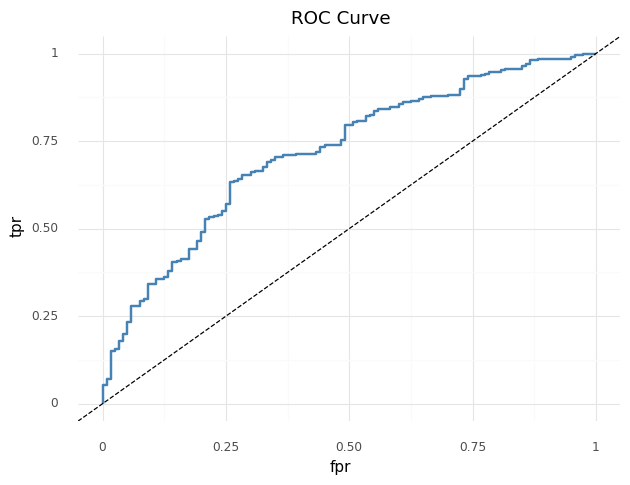

<ggplot: (311157143)>

In [69]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

As the false posite rate increases, we can see that the true positive rate firstly increase at an increasing speed but then slows down after fpr is greater than 0.25. The ROC shows that while over model overall have a rather precise prediction on votes at around 70%, our model have a rather worse performance on predicting the people who would vote, which means that there would be much more people who votes out of our expectatioa.